## Assignment: Optimization methods

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

## Task

Implement different optimization methods wihout using `autograd` or `torch.optim`. You are only allowed to use pytorch as yur numeric computation framework. The only exception is `visualize` function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

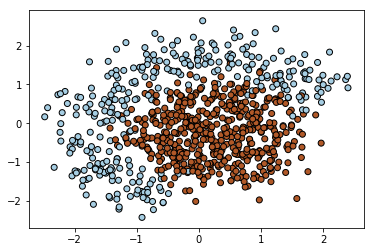

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [3]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1) # add extra dim at pos 1
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor (res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    # Your code here
    X = expand(X)
    w = w.unsqueeze(1)
    w = w.float()
    y_ = torch.mm(X,w)
    return y_


The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X = expand(X)
    w = w.unsqueeze(1).float()
    y = y.unsqueeze(1)
    N = X.shape[0]
    metric = 1-y*(X@w)
    metric[metric<0] = 0
    L = 1/N*torch.sum(metric)
#     print(X.shape,y.shape, w.shape, N, metric.shape, metric)
    return L


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X = expand(X)
    w = w.unsqueeze(1).float()
    y = y.unsqueeze(1)
    N = X.shape[0]
    metric = 1-y*(X@w)
    
    y_tmp = y.clone()
    y_tmp[metric<0] = 0
    grad = -y_tmp*X
#     print(X.shape,y.shape, w.shape, N, metric.shape, grad.shape)
    grad = 1/N*torch.sum(grad, 0)
    return grad
# compute_loss(X,y,torch.tensor([1,1,1,1,1,1]))
# compute_grad(X,y,torch.tensor([1,1,1,1,1,1]))



tensor([-0.1189,  0.2090,  0.6356,  0.6359,  0.2357,  0.2283])

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

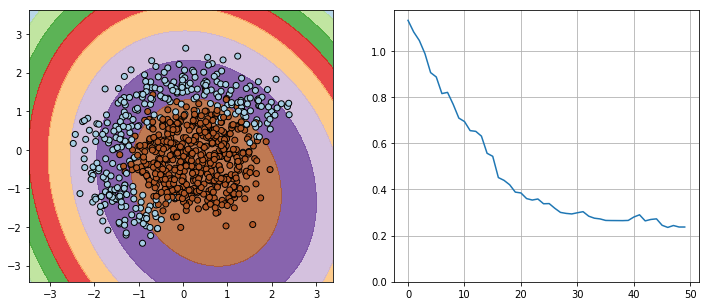

tensor(0.2450)


<Figure size 864x360 with 0 Axes>

In [50]:
# w = torch.Tensor([0.8, -0.31, -0.7, 0.22, -0.14, 0.73])
# w = torch.Tensor([1, 0,0,0,0,0])
import numpy as np
w = np.random.normal(0,0.1, (6,))
w = torch.Tensor(w)


alpha = 0.13

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    if i%(n_iter//10)==0:
        visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

print(w.shape)
visualize(X, y, w, loss, n_iter)
plt.clf()
print(compute_loss(X,y,w))

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

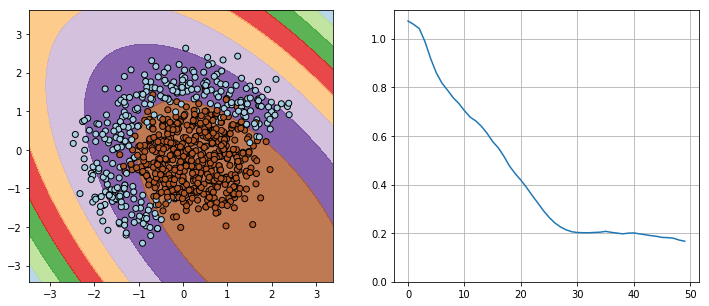

<Figure size 864x360 with 0 Axes>

In [9]:
import numpy as np
w = np.random.normal(0,0.1, (6,))
w = torch.Tensor(w)

alpha = 0.03
mu    =  0.9

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    if i%(n_iter//10)==0:
        visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu*v - alpha * compute_grad(X[ind,:], y[ind], w)
    w = w+v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

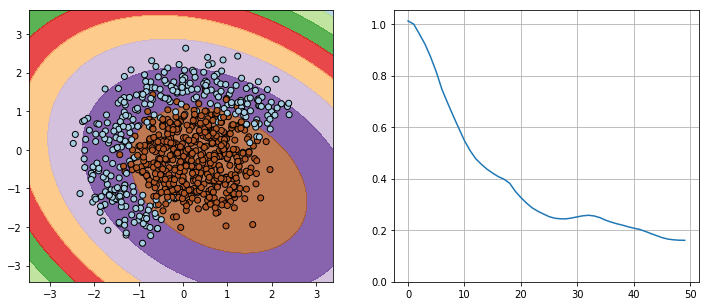

<Figure size 864x360 with 0 Axes>

In [10]:
import numpy as np
w = np.random.normal(0,0.1, (6,))
w = torch.Tensor(w)

alpha = 0.03
mu    =  0.9

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    
    if i%(n_iter//10)==0:
        visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu*v - alpha * compute_grad(X[ind,:], y[ind], w + mu*v)# A small constant for numerical stability
    w = w+v

visualize(X, y, w, loss, n_iter)
plt.clf()

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

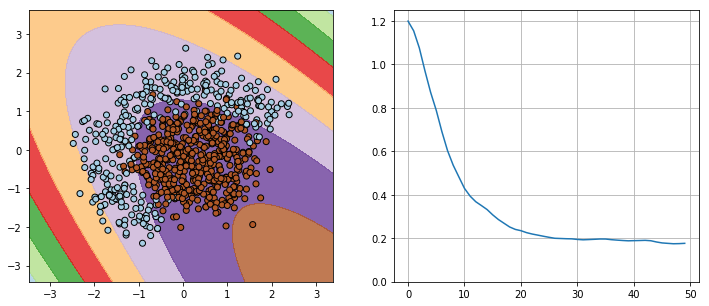

tensor(0.1750)


<Figure size 864x360 with 0 Axes>

In [48]:
import numpy as np

w = np.random.normal(0,0.1, (6,))
w = torch.Tensor(w)

alpha = 0.1
beta = 0.999
mu = 0.9
eps = 0.001

v = torch.zeros_like(w)
g = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)    

    if i%(n_iter//10)==0:
        visualize(X[ind,:], y[ind], w, loss, n_iter)
     
    v = mu*v + (1-mu) * compute_grad(X[ind,:], y[ind],w)
    c = beta*c + (1-beta) * compute_grad(X[ind,:], y[ind],w)**2
    
    w -= alpha/(c**0.5+eps)*v

visualize(X, y, w, loss, n_iter)
plt.clf()
print(compute_loss(X,y,w))